## Imports

In [1]:
import os
import math

import pandas as pd
import geopandas as gpd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px # type: ignore

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm

from datetime import date, timedelta
from tqdm.auto import tqdm

tqdm.pandas()

### Data prep

In [6]:
# Discrete sample data from sf_bay/cruiseall table
df_disc = pd.read_csv('Data Prep/cruiseall_20240711_CLEANED.csv')
df_disc = df_disc.dropna(subset=['calc_chlor']) # drops ~2%
df_disc.datetime = pd.to_datetime(df_disc.datetime)
df_disc['timestamp'] = df_disc.datetime.astype('int64').div(10**9)
display(df_disc.head())

# Peterson Flowthrough data
df_ft = pd.read_parquet('Merges/PETERSON_FINAL.parquet').reset_index(drop=True).drop(columns='index')
df_ft.datetime = pd.to_datetime(df_ft.datetime)
df_ft['timestamp'] = df_ft.datetime.astype('int64').div(10**9)
df_ft['water_temp'] = df_ft['water_temp'].combine_first(df_ft['bow_temp'])
df_ft.rename(columns={'chlor': 'disc_chlor'}, inplace=True)
display(df_ft.head())

,datetime,date,time,station_id,dist,depth,disc_chlor,calc_chlor,chlrat,disc_oxy,calc_oxy,sat_oxy,dscrspm,calcspm,salinity,water_temp,timestamp
0,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,1.0,NaN,2.9,NaN,NaN,8.2,88.0,NaN,96.0,27.63,10.23,786090120.0
1,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,2.0,2.9,2.9,0.4,7.9,8.2,88.0,95.0,98.0,27.65,10.25,786090120.0
2,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,3.0,NaN,2.9,NaN,NaN,8.2,88.0,NaN,98.0,27.69,10.27,786090120.0
3,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,4.0,NaN,2.9,NaN,NaN,8.2,88.0,NaN,96.0,27.73,10.29,786090120.0
4,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,5.0,NaN,2.9,NaN,NaN,8.2,88.0,NaN,95.0,27.75,10.29,786090120.0


,datetime,lat,lon,depth,photic_depth,wind_spd,wind_dir,water_temp,air_temp,bow_temp,...,file,datetime_out,new_lat,new_lon,dist_m,p_id,d_from_start,d_from_station,station_id,timestamp
0,1994-11-29 05:25:21,37.55778,-122.2006,9.5,NaN,2.8,333.0,10.667,5.99,10.667,...,11290520.001,1994-11-29 05:25:21,37.559167,-122.199167,199.311480,1102.0,17.913932,929.348040,30.0,786086721.0
1,1994-11-29 05:25:27,37.55806,-122.2006,9.9,NaN,2.7,341.0,10.677,5.66,10.677,...,11290520.001,1994-11-29 05:25:27,37.559500,-122.199833,173.585801,1104.0,17.990672,998.896984,30.0,786086727.0
2,1994-11-29 05:25:33,37.55861,-122.2006,10.1,NaN,2.9,341.0,10.685,5.83,10.685,...,11290520.001,1994-11-29 05:25:33,37.559500,-122.199833,119.774825,1104.0,17.990672,998.896984,30.0,786086733.0
3,1994-11-29 05:25:39,37.55889,-122.2006,10.3,NaN,2.6,339.0,10.689,5.73,10.689,...,11290520.001,1994-11-29 05:25:39,37.559500,-122.199833,95.772003,1104.0,17.990672,998.896984,30.0,786086739.0
4,1994-11-29 05:25:45,37.55944,-122.2006,10.6,NaN,2.7,342.0,10.691,5.68,10.691,...,11290520.001,1994-11-29 05:25:45,37.559833,-122.200333,49.607724,1107.0,18.058674,1055.890438,30.0,786086745.0


### Dataset Metadata

In [11]:
ft_unique = df_ft.datetime.dt.date.nunique()
# More files than unique days because some runs are broken into multiple files (S to N, N to S)
ft_file = df_ft.file.nunique()
wq_unique = df_disc.datetime.dt.date.nunique()

df_disc_filter = df_disc.dropna(subset=['calc_chlor', 'disc_chlor']).datetime.dt.date.nunique()

print(f'Peterson runs (rough): {ft_unique}')
print(f'Runs by file: {ft_file}')
print(f'WQ measures by date: {wq_unique}')
print(f'WQ measures by date: {df_disc_filter} (with calcuated and discrete value)')

Peterson runs (rough): 524
Runs by file: 607
WQ measures by date: 611
WQ measures by date: 611 (with calcuated and discrete value)


### General Visualizations

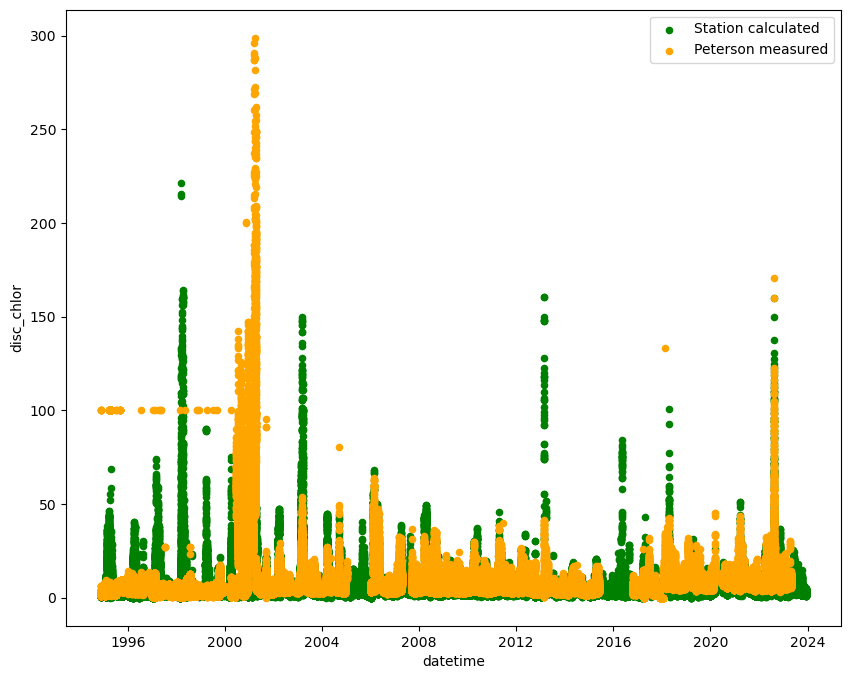

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
df_disc_gen = df_disc.copy()
df_ft_gen = df_ft.sample(n=len(df_disc))

df_ft_gen = df_ft_gen[df_ft_gen.disc_chlor < 300]

df_disc_gen.plot(ax=ax, x='datetime', y='calc_chlor', c='green', kind='scatter', label='Station calculated')
df_ft_gen.plot(ax=ax, x='datetime', y='disc_chlor', c='orange', kind='scatter', label='Peterson measured')
plt.show()

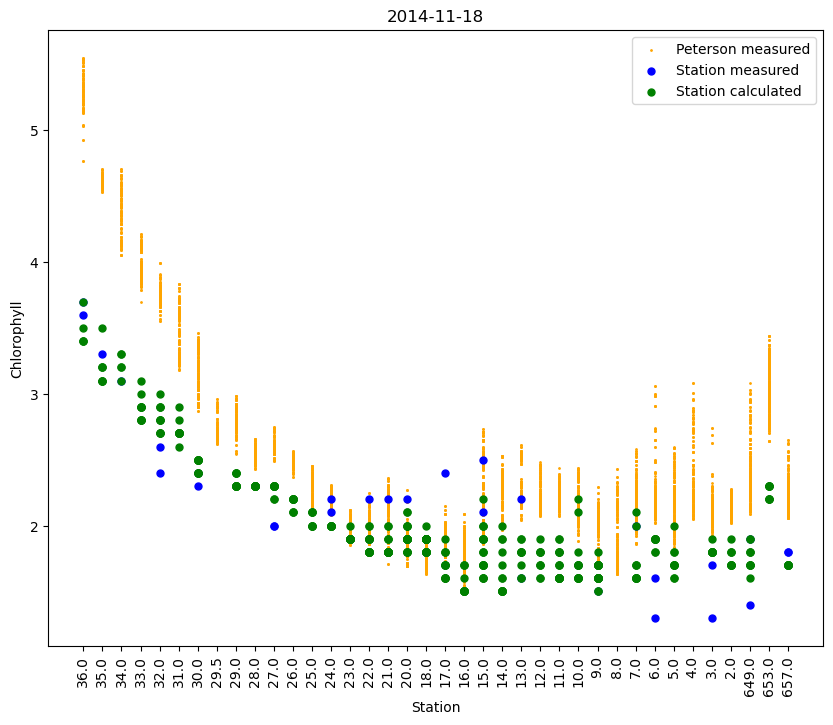

In [22]:
# date(year=2014, month=11, day=18) -- refline
# date(year=1995, month=9, day=21) -- non linear
# date(year=2006, month=8, day=2) -- high variation in calculated data

run_date = date(year=2014, month=11, day=18)

df_disc_gen = df_disc.copy()
df_ft_gen = df_ft.copy()

df_disc_gen = df_disc_gen[df_disc_gen.datetime.dt.date == run_date]
df_ft_gen = df_ft_gen[df_ft_gen.datetime.dt.date == run_date]

# For dates before 1/1/2000
if run_date < date(year=2000, month=1, day=1):
    df_ft_gen = df_ft_gen[df_ft_gen.disc_chlor < 99]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_ft_gen['station_id'].astype(str), df_ft_gen['disc_chlor'], c='orange', label='Peterson measured', s=1)
ax.scatter(df_disc_gen['station_id'].astype(str), df_disc_gen['disc_chlor'], c='blue', label='Station measured', s=25)
ax.scatter(df_disc_gen['station_id'].astype(str), df_disc_gen['calc_chlor'], c='green', label='Station calculated', s=25)

plt.title(run_date)
plt.xlabel('Station')
plt.ylabel('Chlorophyll')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [27]:
temp = df_ft.copy()
print(temp.groupby(temp.datetime.dt.year)['water_temp'].mean())
temp = temp[temp.datetime.dt.year == '2016']
print(temp.head())

datetime
1994    10.614170
1995    15.268316
1996    15.344211
1997    16.337008
1998    15.083627
1999    13.448276
2000    15.074855
2001    15.354620
2002    15.319628
2003    15.922430
2004    16.070159
2005    10.740860
2006    15.018125
2007    12.256789
2008    16.209897
2009    15.775146
2010    16.080439
2011    16.145869
2012    16.053800
2013    14.712775
2014    18.487124
2015    15.493723
2016          NaN
2017    18.239570
2018    16.172109
2019    16.980955
2020    15.681179
2021    17.979920
2022          NaN
2023          NaN
Name: bow_temp, dtype: float64
Empty DataFrame
Columns: [datetime, lat, lon, depth, photic_depth, wind_spd, wind_dir, water_temp, air_temp, bow_temp, barometer, disc_chlor, turbidity, suspended_part, salinity, fluor_switch, comment, mark, dataset, file, datetime_out, new_lat, new_lon, dist_m, p_id, d_from_start, d_from_station, station_id, timestamp]
Index: []

[0 rows x 29 columns]
